In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from tabulate import tabulate

from collections import Counter
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bower\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Collecting and cleaning data sets

In [2]:
sms_data, email_data = [], []
sms_count, email_count = 0, 0

# SMS DATASETS

# https://www.kaggle.com/datasets/galactus007/sms-smishing-collection-data-set/
df = pd.read_csv("datasets/sms_messaging.csv")
df = df.loc[df["label"] == 1]

sms_count += len(df)
sms_data = np.concatenate((sms_data, np.array(df["sms"])), axis=0)

# https://data.mendeley.com/datasets/f45bkkt8pr/1
df = pd.read_csv("datasets/sms_phishing.csv")
df = df.loc[df["LABEL"] == "Smishing"]

sms_count += len(df)
sms_data = np.concatenate((sms_data, np.array(df["TEXT"])), axis=0)

print(sms_count)


# EMAIL DATASETS

# https://www.kaggle.com/datasets/charlottehall/phishing-email-data-by-type
df = pd.read_csv("datasets/phishing_data_by_type.csv")
df = df.loc[df["Type"] != "False Positives "]

email_count += len(df)
email_data = np.concatenate((email_data, (np.array(df["Subject"] + " " + df["Text"]))), axis=0)

# https://www.kaggle.com/datasets/subhajournal/phishingemails
df = pd.read_csv("datasets/Phishing_Email.csv")
df = df.loc[df["Email Type"] == "Phishing Email"]

email_count += len(df)
email_data = np.concatenate((email_data, (np.array(df["Email Text"]))), axis=0)

print(email_count)

1363
7448


In [3]:
def clean_text(text):
    text = str(text)
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

clean_sms = [clean_text(text) for text in sms_data]
clean_email = [clean_text(text) for text in email_data]

## Tables and Graphs

In [4]:
def create_sector_table(sector_counts):
    table = tabulate(sector_counts.items(), headers=['Sector', 'Count'], tablefmt="fancy_grid", numalign="center")
    print(table)

def visualize_sector_counts(labels, data):
    counts = Counter(labels)

    # Increase the figure size
    fig, ax = plt.subplots(figsize=(10, 8))

    bars = ax.bar(counts.keys(), counts.values())

    # Add labels to the bars with adjusted font size
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=8)

    ax.set_xlabel('Sectors', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    if data == 0:
        ax.set_title('Phishing SMS Counts by Sector', fontsize=16)
    else:
        ax.set_title('Phishing Email Counts by Sector', fontsize=16)

    # Explicitly set rotation angle for x-axis labels
    plt.xticks(rotation=90)

    plt.show()

## Keyword search to assign attacks to sectors

In [5]:
def keyword_search(sector, keywords, data):
    count = 0
    emails, labels = [], []

    pattern = "|".join(map(re.escape, keywords))
    pattern = r"\b({})\b".format(pattern)

    for index, email in enumerate(data, start=1):
        matches = re.findall(pattern, email)

        if matches:
            emails.append(email)
            labels.append(sector)
            count += 1

    return count, emails, labels

## Run search on datasets

╒═══════════╤═════════╕
│ Sector    │  Count  │
╞═══════════╪═════════╡
│ finance   │   14    │
├───────────┼─────────┤
│ online    │   35    │
├───────────┼─────────┤
│ gov       │    3    │
├───────────┼─────────┤
│ health    │    6    │
├───────────┼─────────┤
│ tech      │   60    │
├───────────┼─────────┤
│ education │    3    │
├───────────┼─────────┤
│ travel    │   88    │
├───────────┼─────────┤
│ job       │    2    │
├───────────┼─────────┤
│ shopping  │   91    │
├───────────┼─────────┤
│ social    │   51    │
╘═══════════╧═════════╛


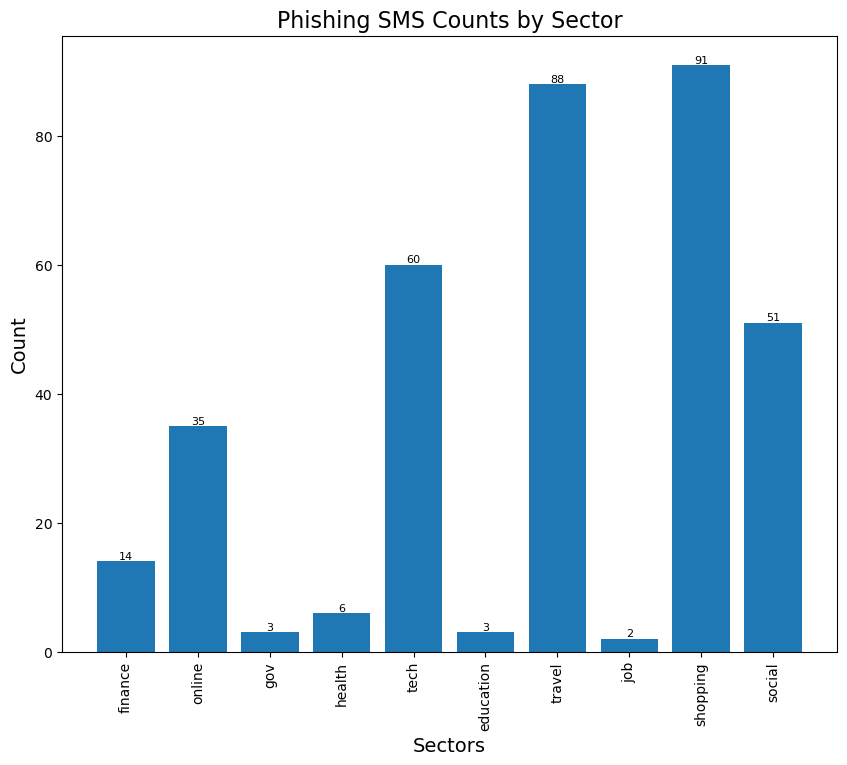

╒═══════════╤═════════╕
│ Sector    │  Count  │
╞═══════════╪═════════╡
│ finance   │   990   │
├───────────┼─────────┤
│ online    │   600   │
├───────────┼─────────┤
│ gov       │   882   │
├───────────┼─────────┤
│ health    │   825   │
├───────────┼─────────┤
│ tech      │  1643   │
├───────────┼─────────┤
│ education │   650   │
├───────────┼─────────┤
│ travel    │   358   │
├───────────┼─────────┤
│ job       │   858   │
├───────────┼─────────┤
│ shopping  │  2010   │
├───────────┼─────────┤
│ social    │   719   │
╘═══════════╧═════════╛


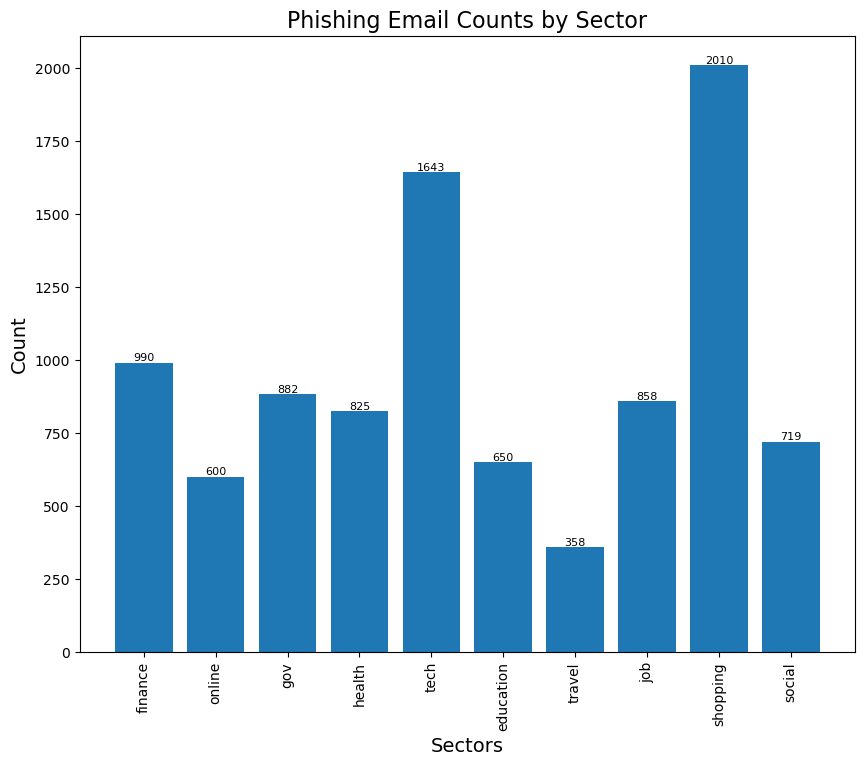

In [6]:
all_keywords = {
        "finance": ["banking", "credit card", "wire transfer", "investment", "financial", "atm"],
        "online": ["social media", "privacy policy", "subscription", "online shopping", "online gaming", "tech", "free trial", "product recall", "friend request", "profile update", "order confirmation", "discounts", "discount", "return policy", "exchange policy", "shopping cart", "software updates", "software update", "device", "game", "customer feedback", "gift card"],
        "gov": ["government", "job opportunities", "job opportunity", "legal", "nonprofit", "scholarships", "financial aid", "grants", "grant", "social security", "workplace", "campus", "tuition", "transcripts", "transcript", "academic", "student loans", "student loan", "fundraising", "volunteer", "donation", "court", "criminal", "crime", "law", "jury", "payroll", "employee", "vote", "public service", "passport renewal"],
        "health": ["healthcare", "health", "pharmacy", "covid", "covid-19", "medicine", "medical", "medication", "medicare", "patient", "electricity", "utility", "travel", "airline"],
        "tech": ["technology", "software", "hardware", "data breach", "cybersecurity", "hack", "data privacy", "internet", "network", "IT support", "digital", "cloud computing", "AI", "machine learning", "automation", "programming", "coding"],
        "education": ["education", "school", "university", "college", "class", "course", "scholarship", "study", "academic", "student", "teacher", "learning", "online education", "coursework", "exam", "graduation"],
        "travel": ["travel", "vacation", "flight", "hotel", "tour", "booking", "holiday", "destination", "cruise"],
        "job": ["job", "career", "employment", "resume", "interview", "hiring", "opportunity", "position"],
        "shopping": ["shopping", "sale", "discount", "offer", "deal", "purchase", "buy", "shopping cart", "online store"],
        "social": ["social", "friends", "network", "invitation", "event", "connect", "community", "friendship"]
    }


# SMS
sector_counts = {}
for sector, keywords in all_keywords.items():
    count, _, _ = keyword_search(sector, keywords, clean_sms)
    sector_counts[sector] = count
    
create_sector_table(sector_counts)
visualize_sector_counts(sector_counts, 0)

# EMAIL
sector_counts = {}
for sector, keywords in all_keywords.items():
    count, _, _ = keyword_search(sector, keywords, clean_email)
    sector_counts[sector] = count
    
create_sector_table(sector_counts)
visualize_sector_counts(sector_counts, 1)

## K-Means Clustering

In [7]:
# Clustering
# X = clean_email
X = clean_sms

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Create a TF-IDF vectorizer to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

n_clusters = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X_clusters = kmeans.fit_predict(X_tfidf)

# Create an array to store the total TF-IDF values for each word in each cluster
cluster_word_tfidf_sums = []

for cluster_id in range(n_clusters):
    # Select the emails that belong to the current cluster
    cluster_indices = [i for i, cluster in enumerate(X_clusters) if cluster == cluster_id]

    # Create a submatrix containing only the emails in this cluster
    cluster_submatrix = X_tfidf[cluster_indices]

    # Sum the TF-IDF values for each word across all emails in the cluster
    word_tfidf_sums = np.array(cluster_submatrix.sum(axis=0))[0]

    # Get the feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Create a list of (word, total TF-IDF) pairs
    cluster_word_tfidf_sums.append(list(zip(feature_names, word_tfidf_sums)))

# Print the most common words for each cluster
N = 10
for cluster_id, word_tfidf_sums in enumerate(cluster_word_tfidf_sums):
    print(f"\nCluster {cluster_id} - Most common words:")
    sorted_words = sorted(word_tfidf_sums, key=lambda x: x[1], reverse=True)
    for word, tfidf_sum in sorted_words[:N]:
        print(f"{word}: {tfidf_sum:.3f}")


Cluster 0 - Most common words:
prize: 26.703
claim: 16.145
guaranteed: 14.622
urgent: 14.562
call: 13.813
2000: 13.728
contact: 12.481
12hrs: 12.135
valid: 12.099
land: 10.522

Cluster 1 - Most common words:
call: 23.775
free: 23.194
txt: 22.525
stop: 22.499
ur: 21.826
claim: 20.222
text: 17.203
receive: 15.437
selected: 14.270
get: 14.219

Cluster 2 - Most common words:
message: 15.237
please: 13.358
customer: 12.997
call: 11.481
account: 8.458
immediately: 7.975
expires: 7.806
identifier: 7.454
unredeemed: 7.454
points: 7.407

Cluster 3 - Most common words:
free: 16.752
reply: 12.032
mins: 11.519
video: 10.207
mobile: 10.118
call: 10.078
08000930705: 10.059
camcorder: 8.870
750: 8.447
update: 8.314

Cluster 4 - Most common words:
rreveal: 7.378
specialcall: 7.378
ufind: 7.378
looking: 7.320
admirer: 7.109
secret: 7.109
thinks: 7.109
make: 6.925
contact: 4.648
ur: 4.515

Cluster 5 - Most common words:
cash: 9.361
sae: 8.632
5000: 8.024
holiday: 7.999
await: 7.967
collection: 7.962
tc

In [8]:
# Sample SMS texts
# X = clean_sms
X = clean_email

# Text preprocessing and counting word occurrences
word_counter = Counter()
for text in X:
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Split text into words and update counter
    words = text.split()
    word_counter.update(words)

# Select top N words
top_words = word_counter.most_common(25)  # Adjust the number as needed

# Print the results
print("Top Words:")
for word, count in top_words:
    print(f"{word}: {count} occurrences")

Top Words:
â: 7414 occurrences
email: 6698 occurrences
1: 4592 occurrences
free: 4336 occurrences
2: 4046 occurrences
3: 3995 occurrences
com: 3974 occurrences
get: 3943 occurrences
please: 3929 occurrences
company: 3917 occurrences
money: 3908 occurrences
information: 3876 occurrences
one: 3626 occurrences
business: 3609 occurrences
us: 3561 occurrences
time: 3223 occurrences
5: 3188 occurrences
e: 3129 occurrences
http: 3116 occurrences
report: 3115 occurrences
new: 3093 occurrences
click: 2986 occurrences
20: 2800 occurrences
make: 2771 occurrences
order: 2722 occurrences
